In [111]:
import cv2
import matplotlib.pyplot as plt
import math
import time
import os
import shutil
from scipy.ndimage import gaussian_filter
import scipy.signal
from skimage import color, io
import numpy as np
import matplotlib.pyplot as plt
from skimage import data, img_as_float
from skimage.segmentation import (morphological_chan_vese,
                                  morphological_geodesic_active_contour,
                                  inverse_gaussian_gradient,
                                  checkerboard_level_set)

from scipy import ndimage as ndi

from skimage import data
from skimage.metrics import (adapted_rand_error,
                              variation_of_information)
from skimage.filters import sobel
from skimage.measure import label
from skimage.util import img_as_float
from skimage.feature import canny
from skimage.morphology import remove_small_objects
from skimage.segmentation import (morphological_geodesic_active_contour,
                                  inverse_gaussian_gradient,
                                  watershed,
                                  mark_boundaries)
from time import time

%matplotlib inline

In [112]:
img=cv2.imread("1.jpg")
gray_img=cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

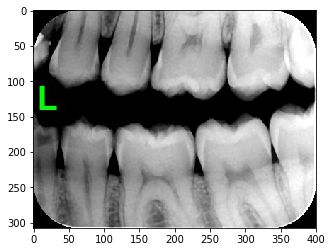

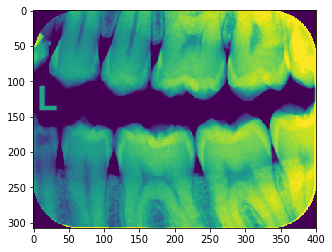

In [113]:
plt.figure()
plt.imshow(img)
plt.figure()
plt.imshow(gray_img)

In [101]:
print(gray_img.shape)

(308, 401)


147


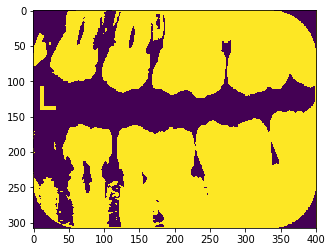

In [103]:
treshhold_otsu=int(np.median(gray_img))
print(treshhold_otsu)
# Otsu's thresholding
ret2,th2 = cv2.threshold(gray_img,0,treshhold_otsu,cv2.THRESH_OTSU)
plt.figure()
plt.imshow(th2)

In [104]:
import skfuzzy as fuzz

In [105]:
def change_color_fuzzycmeans(cluster_membership, clusters):
    img = []
    for pix in cluster_membership.T:
        img.append(clusters[np.argmax(pix)])
    return img

def readimage():
    folder = 'image-cancer/'
    list_images = os.listdir(folder)
    list_img = []
    for i in list_images:
        path = folder+i
        print(path)
        img = cv2.imread(path)
        rgb_img = img.reshape((img.shape[0] * img.shape[1], 3))
        list_img.append(rgb_img)
        
    return list_img

def bwarea(img):
    row = img.shape[0]
    col = img.shape[1]
    total = 0.0
    for r in range(row-1):
        for c in range(col-1):
            sub_total = img[r:r+2, c:c+2].mean()
            if sub_total == 255:
                total += 1
            elif sub_total == (255.0/3.0):
                total += (7.0/8.0)
            elif sub_total == (255.0/4.0):
                total += 0.25
            elif sub_total == 0:
                total += 0
            else:
                r1c1 = img[r,c]
                r1c2 = img[r,c+1]
                r2c1 = img[r+1,c]
                r2c2 = img[r+1,c+1]
                
                if (((r1c1 == r2c2) & (r1c2 == r2c1)) & (r1c1 != r2c1)):
                    total += 0.75
                else:
                    total += 0.5
    return total
            
def imclearborder(imgBW):

    # Given a black and white image, first find all of its contours
    radius = 2
    imgBWcopy = imgBW.copy()
    image, contours,hierarchy = cv2.findContours(imgBWcopy.copy(), cv2.RETR_LIST, 
        cv2.CHAIN_APPROX_SIMPLE)

    # Get dimensions of image
    imgRows = imgBW.shape[0]
    imgCols = imgBW.shape[1]    

    contourList = [] # ID list of contours that touch the border

    # For each contour...
    for idx in np.arange(len(contours)):
        # Get the i'th contour
        cnt = contours[idx]

        # Look at each point in the contour
        for pt in cnt:
            rowCnt = pt[0][1]
            colCnt = pt[0][0]

            # If this is within the radius of the border
            # this contour goes bye bye!
            check1 = (rowCnt >= 0 and rowCnt < radius) or (rowCnt >= imgRows-1-radius and rowCnt < imgRows)
            check2 = (colCnt >= 0 and colCnt < radius) or (colCnt >= imgCols-1-radius and colCnt < imgCols)

            if check1 or check2:
                contourList.append(idx)
                break

    for idx in contourList:
        cv2.drawContours(imgBWcopy, contours, idx, (0,0,0), -1)

    return imgBWcopy

#### bwareaopen definition
def bwareaopen(imgBW, areaPixels):
    # Given a black and white image, first find all of its contours
    imgBWcopy = imgBW.copy()
    image, contours,hierarchy = cv2.findContours(imgBWcopy.copy(), cv2.RETR_LIST, 
        cv2.CHAIN_APPROX_SIMPLE)

    # For each contour, determine its total occupying area
    for idx in np.arange(len(contours)):
        area = cv2.contourArea(contours[idx])
        if (area >= 0 and area <= areaPixels):
            cv2.drawContours(imgBWcopy, contours, idx, (0,0,0), -1)

    return imgBWcopy      

def imfill(im_th):
    
    im_floodfill = im_th.copy()
    # Mask used to flood filling.
    
    # Notice the size needs to be 2 pixels than the image.
    h, w = im_th.shape[:2]
    mask = np.zeros((h+2, w+2), np.uint8)

    # Floodfill from point (0, 0)
    cv2.floodFill(im_floodfill, mask, (0,0), 255);

    # Invert floodfilled image
    im_floodfill_inv = cv2.bitwise_not(im_floodfill)

    # Combine the two images to get the foreground.
    im_out = im_th | im_floodfill_inv
    
    return im_out

In [93]:
rgb_cvt=cv2.cvtColor(th2,cv2.COLOR_GRAY2RGB)
rgb_img =rgb_cvt.reshape((rgb_cvt.shape[0] * rgb_cvt.shape[1],3))
cv2.imshow("rgb_img",rgb_cvt)
cv2.waitKey(0) 
cv2.destroyAllWindows() 

Fuzzy time for cluster 2
0.5309703350067139 seconds
Bwarea : 0.0

Fuzzy time for cluster 3
0.638007402420044 seconds
Bwarea : 0.0

Fuzzy time for cluster 6
0.731989860534668 seconds
Bwarea : 3974.5

Fuzzy time for cluster 8
0.7529654502868652 seconds
Bwarea : 3974.5

Fuzzy time for cluster 10
0.8110013008117676 seconds
Bwarea : 3974.5




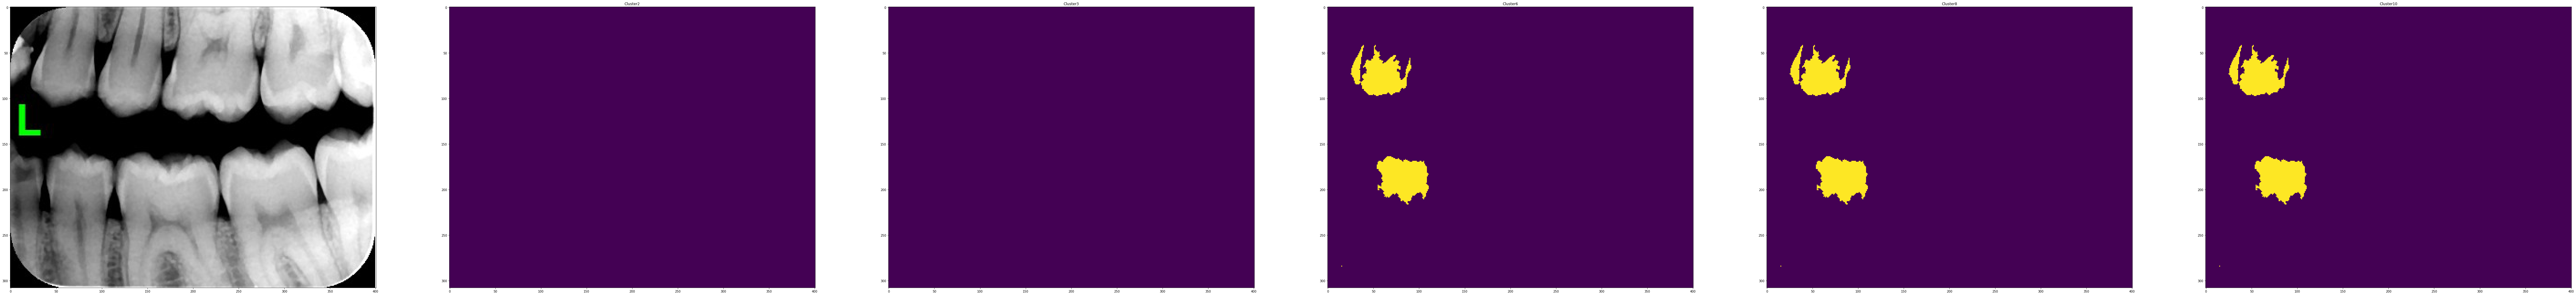

In [126]:
clusters = [2,3,6,8,10]

rgb_img = img.reshape((img.shape[0] * img.shape[1], 3))

plt.figure(figsize=(150,150))
plt.subplot(1,6,1)
plt.imshow(img)
    
for i,cluster in enumerate(clusters):           
    # Fuzzy C Means
    new_time = time()

    # error = 0.001
    # maximum iteration = 1000
    # cluster = 2,3,6,8

    cntr, u, u0, d, jm, p, fpc = fuzz.cluster.cmeans(rgb_img.T, cluster, 2, error=0.001, maxiter=2, init=None,seed=42)

    new_img = change_color_fuzzycmeans(u,cntr)

    fuzzy_img = np.reshape(new_img,shape).astype(np.uint8)
    cv2.imshow("fuzzy_img "+str(i),fuzzy_img)
    ret, seg_img = cv2.threshold(fuzzy_img,np.max(fuzzy_img)-1,255,cv2.THRESH_BINARY)

    print('Fuzzy time for cluster',cluster)
    print(time() - new_time,'seconds')
    seg_img_1d = seg_img[:,:,1]


    bwfim1 = bwareaopen(seg_img_1d, 100)
    bwfim2 = imclearborder(bwfim1)
    bwfim3 = imfill(bwfim2)

    print('Bwarea : '+str(bwarea(bwfim3)))
    print()

    plt.subplot(1,6,i+2)
    plt.imshow(bwfim3)
    name = 'Cluster'+str(cluster)
    plt.title(name)
    
name = 'segmented.png'
plt.savefig(name)
print()
cv2.waitKey(0) 
cv2.destroyAllWindows() 